In [1]:
import pandas as pd
global_temp = pd.read_csv("/content/GlobalTemperatures.csv")
print(global_temp.shape)
print(global_temp.columns)
print(global_temp.info())
print(global_temp.isnull().sum())

(3192, 9)
Index(['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
       'LandMinTemperature', 'LandMinTemperatureUncertainty',
       'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   

In [12]:
import pandas as pd

#Data Preparation
def wrangle(df):
    df = df.copy()
    df = df.drop(columns=["LandAverageTemperatureUncertainty", "LandMaxTemperatureUncertainty",
                          "LandMinTemperatureUncertainty", "LandAndOceanAverageTemperatureUncertainty"], axis=1)

    # Indentation of converttemp corrected to be inside the function
    def converttemp(x):
        x = (x * 1.8) + 32
        return float(x)

    # The following operations are indented to be inside the function
    df["LandAverageTemperature"] = df["LandAverageTemperature"].apply(converttemp)
    df["LandMaxTemperature"] = df["LandMaxTemperature"].apply(converttemp)
    df["LandMinTemperature"] = df["LandMinTemperature"].apply(converttemp)
    df["LandAndOceanAverageTemperature"] = df["LandAndOceanAverageTemperature"].apply(converttemp)
    df["dt"] = pd.to_datetime(df["dt"])
    df["Month"] = df["dt"].dt.month
    df["Year"] = df["dt"].dt.year
    df = df.drop("dt", axis=1)
    df = df.drop("Month", axis=1)
    df = df[df.Year >= 1850]
    df = df.set_index(["Year"])
    df = df.dropna()
    return df

global_temp = pd.read_csv("/content/GlobalTemperatures.csv")
global_temp = wrangle(global_temp) # assign the result of wrangle to global_temp
print(global_temp.head())

      LandAverageTemperature  LandMaxTemperature  LandMinTemperature  \
Year                                                                   
1850                 33.3482             46.8356             26.2292   
1850                 37.5278             49.9460             27.8762   
1850                 40.9172             50.6246             28.5710   
1850                 44.9906             55.2812             33.8324   
1850                 50.0072             60.1790             38.8598   

      LandAndOceanAverageTemperature  
Year                                  
1850                         55.0994  
1850                         56.4584  
1850                         57.2774  
1850                         58.4006  
1850                         59.9126  


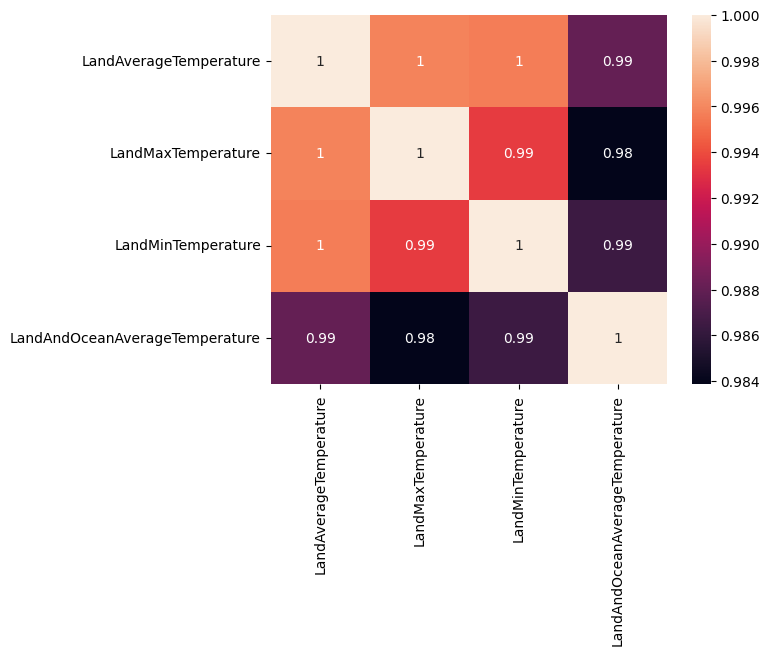

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
corrMatrix = global_temp.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [14]:
target = "LandAndOceanAverageTemperature"
y = global_temp[target]
x = global_temp[["LandAverageTemperature", "LandMaxTemperature", "LandMinTemperature"]]

In [15]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(x, y, test_size=0.25, random_state=42)
print(xtrain.shape)
print(xval.shape)
print(ytrain.shape)

(1494, 3)
(498, 3)
(1494,)


In [16]:
from sklearn.metrics import mean_squared_error
ypred = [ytrain.mean()] * len(ytrain)
print("Baseline MAE: ", round(mean_squared_error(ytrain, ypred), 5))

Baseline MAE:  5.29374


In [18]:

from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline # Import make_pipeline
from sklearn.preprocessing import StandardScaler # Import StandardScaler

forest = make_pipeline(
    SelectKBest(k="all"),
    StandardScaler(),
    RandomForestRegressor(
        n_estimators=100,
        max_depth=50,
        random_state=77,
        n_jobs=-1
    )
)
forest.fit(xtrain, ytrain)

Pipeline(steps=[('selectkbest', SelectKBest(k='all')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=50, n_jobs=-1,
                                       random_state=77))])

In [20]:
import numpy as np
# Change: Predict on the validation set for calculating errors
ypred_val = forest.predict(xval) # Get predictions for validation set

# Change: Calculate errors using ypred_val (predictions for validation set)
errors = abs(ypred_val - yval)
mape = 100 * (errors / yval) # Change: Divide errors by yval instead of ytrain
accuracy = 100 - np.mean(mape)
print("Random Forest Model: ", round(accuracy, 2), "%")

Random Forest Model:  99.59 %
